In [ ]:
# === IMPORTS ===
import os
import json
import time
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === API setup ===
api_key = "API Key"  # 👈 Insert your real API key here
api_url = "https://api.anthropic.com/v1/messages"
model_name = "claude-3-haiku-20240307"

headers = {
    "x-api-key": api_key,
    "anthropic-version": "2023-06-01",
    "content-type": "application/json",
}

# === Paths ===
base_path = Path.home() / "Desktop" / "processed_subs"
subs_dir = base_path
summaries_dir = base_path / "summaries"
prompts_dir = base_path / "prompts_progress_and_woke"
output_dir = base_path / "scored_progress_and_woke"

prompts_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

# === Load match file ===
matches_df = pd.read_csv("final_matches_updated2.csv")
matches_df = matches_df.dropna(subset=["subtitle_filename"])

# === Helper: call Claude ===
def call_claude(prompt):
    payload = {
        "model": model_name,
        "max_tokens": 1000,
        "temperature": 0,
        "system": "You are a strict JSON-returning film analyst. Only respond in the precise JSON structure requested.",
        "messages": [{"role": "user", "content": prompt}]
    }

    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 429:
        print(f"⚠️ Rate limit hit. Waiting 60 seconds...")
        time.sleep(60)
        return call_claude(prompt)

    if response.status_code != 200:
        print(f"⚠️ API Error {response.status_code}: {response.text}")
        return None

    data = response.json()
    content = data["content"][0]["text"]

    try:
        return json.loads(content)
    except json.JSONDecodeError:
        print(f"⚠️ JSON parsing error: {content}")
        return None

# === Prompt generator for progress and woke scores ===
def create_progress_and_woke_prompt(summary, dialogue_text):
    return f"""
You are an AI film researcher analyzing cultural and political narratives in film.  
You will receive a movie summary and a chunk of dialogue.

Your task is to score the film across two broad areas:

---

## 1. Progress Narrative Scoring

For each of the following dimensions, score from 0 (strongly regressive or skeptical) to 1 (strongly progressive or embracing), based on how the film portrays each theme:

- technological_progress: Attitudes toward science, innovation, AI, automation, etc.
- social_progress: Attitudes toward inclusion, gender equity, race, LGBTQ+, etc.
- economic_progress: Views on capitalism, wealth inequality, class mobility.
- institutional_trust: Views on institutions like government, media, police, science.
- global_vs_national: Favorability toward global cooperation vs. nationalism.

---

## 2. Culture War / Woke Dynamics

Assess how the film participates in culture war discourse:

- woke_presence_score: To what extent are DEI values embedded in the film (0 = not at all, 1 = strongly)
- anti_woke_pushback_score: To what extent does the film resist or mock progressive ideas (0 = none, 1 = strong)
- culture_war_themes: List 1–3 themes like “cancel culture”, “free speech”, “anti-feminism”, “identity politics”

---

## Output format — return ONLY this JSON:

{{
  "progress_scores": {{
    "technological_progress": <float>,
    "social_progress": <float>,
    "economic_progress": <float>,
    "institutional_trust": <float>,
    "global_vs_national": <float>
  }},
  "culture_scores": {{
    "woke_presence_score": <float>,
    "anti_woke_pushback_score": <float>,
    "culture_war_themes": [<string>, ...]
  }},
  "confidence": <float>
}}

---

Use both the summary (for character/political framing) and the dialogue (for tone, conflict, values).

---

Movie Summary:
\"\"\"{summary}\"\"\"

Dialogue Chunk:
\"\"\"{dialogue_text}\"\"\"
"""

# === Subtitle merging logic ===
def merge_subtitles(subs, max_chars=4000):
    text_blocks = []
    for line in subs:
        if line.get("text"):
            clean_line = line["text"].strip()
            text_blocks.append(clean_line)
    full_text = " ".join(text_blocks)
    return full_text[:max_chars] + " ..." if len(full_text) > max_chars else full_text

# === Main scoring loop ===
for _, row in tqdm(matches_df.iterrows(), total=len(matches_df), desc="Scoring progress + woke"):
    filename = row["subtitle_filename"]

    json_path = subs_dir / f"{filename}.json"
    summary_path = summaries_dir / f"{filename}_summary.txt"
    prompt_path = prompts_dir / f"{filename}_progress_and_woke_prompt.json"
    output_path = output_dir / f"{filename}_progress_and_woke_scored.json"

    if not json_path.exists() or not summary_path.exists():
        print(f"⚠️ Missing files for {filename}. Skipping.")
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        subs = json.load(f)

    with open(summary_path, "r", encoding="utf-8") as f:
        summary = f.read().strip()

    dialogue_text = merge_subtitles(subs)
    prompt = create_progress_and_woke_prompt(summary, dialogue_text)

    with open(prompt_path, "w", encoding="utf-8") as f:
        json.dump({"prompt": prompt}, f, indent=2)

    result = call_claude(prompt)

    if result is not None:
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(result, f, indent=2)
        print(f"✅ Scored: {filename}")
    else:
        print(f"❌ Failed scoring: {filename}")

    time.sleep(1.5)  # Respect rate limits


In [ ]:
# === IMPORTS ===
import os
import json
import time
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === API setup ===
api_key = "API Key"  # 👈 Insert your real API key here
api_url = "https://api.anthropic.com/v1/messages"
model_name = "claude-3-haiku-20240307"

headers = {
    "x-api-key": api_key,
    "anthropic-version": "2023-06-01",
    "content-type": "application/json",
}

# === Paths ===
base_path = Path.home() / "Desktop" / "processed_subs"
subs_dir = base_path
summaries_dir = base_path / "summaries"
prompts_dir = base_path / "prompts_progress_and_woke_chunks"
output_dir = base_path / "scored_progress_and_woke_chunks"

prompts_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

# === Load match file ===
matches_df = pd.read_csv("final_matches.csv")
matches_df = matches_df.dropna(subset=["subtitle_filename"])

# === Claude call ===
def call_claude(prompt):
    payload = {
        "model": model_name,
        "max_tokens": 1000,
        "temperature": 0,
        "system": "You are a strict JSON-returning film analyst. Only respond in the precise JSON structure requested.",
        "messages": [{"role": "user", "content": prompt}]
    }

    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 429:
        print(f"⚠️ Rate limit hit. Waiting 60 seconds...")
        time.sleep(60)
        return call_claude(prompt)

    if response.status_code != 200:
        print(f"⚠️ API Error {response.status_code}: {response.text}")
        return None

    data = response.json()
    content = data["content"][0]["text"]

    try:
        return json.loads(content)
    except json.JSONDecodeError:
        print(f"⚠️ JSON parsing error: {content}")
        return None

# === Prompt generator ===
def create_progress_and_woke_prompt(summary, dialogue_text):
    return f"""
You are an AI film researcher analyzing cultural and political narratives in film.  
You will receive a movie summary and a chunk of dialogue.

Your task is to score the film across two broad areas:

---

## 1. Progress Narrative Scoring

For each of the following dimensions, score from 0 (strongly regressive or skeptical) to 1 (strongly progressive or embracing), based on how the film portrays each theme:

- technological_progress: Attitudes toward science, innovation, AI, automation, etc.
- social_progress: Attitudes toward inclusion, gender equity, race, LGBTQ+, etc.
- economic_progress: Views on capitalism, wealth inequality, class mobility.
- institutional_trust: Views on institutions like government, media, police, science.
- global_vs_national: Favorability toward global cooperation vs. nationalism.

---

## 2. Culture War / Woke Dynamics

Assess how the film participates in culture war discourse:

- woke_presence_score: To what extent are DEI values embedded in the film (0 = not at all, 1 = strongly)
- anti_woke_pushback_score: To what extent does the film resist or mock progressive ideas (0 = none, 1 = strong)
- culture_war_themes: List 1–3 themes like “cancel culture”, “free speech”, “anti-feminism”, “identity politics”

---

## Output format — return ONLY this JSON:

{{
  "progress_scores": {{
    "technological_progress": <float>,
    "social_progress": <float>,
    "economic_progress": <float>,
    "institutional_trust": <float>,
    "global_vs_national": <float>
  }},
  "culture_scores": {{
    "woke_presence_score": <float>,
    "anti_woke_pushback_score": <float>,
    "culture_war_themes": [<string>, ...]
  }},
  "confidence": <float>
}}

---

Use both the summary (for character/political framing) and the dialogue (for tone, conflict, values).

---

Movie Summary:
\"\"\"{summary}\"\"\"

Dialogue Chunk:
\"\"\"{dialogue_text}\"\"\"
"""

# === Subtitle chunking function ===
def chunk_dialogue(subs, chunk_size=5000, overlap=200):
    text_blocks = []
    for line in subs:
        if line.get("text"):
            text_blocks.append(line["text"].strip())
    full_text = " ".join(text_blocks)

    # Break into overlapping chunks
    chunks = []
    start = 0
    while start < len(full_text):
        end = start + chunk_size
        chunks.append(full_text[start:end])
        start = end - overlap  # overlap avoids abrupt sentence cuts
    return chunks

# === Main scoring loop ===
for _, row in tqdm(matches_df.iterrows(), total=len(matches_df), desc="Scoring progress + woke (chunked)"):
    filename = row["subtitle_filename"]

    json_path = subs_dir / f"{filename}.json"
    summary_path = summaries_dir / f"{filename}_summary.txt"

    if not json_path.exists() or not summary_path.exists():
        print(f"⚠️ Missing files for {filename}. Skipping.")
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        subs = json.load(f)

    with open(summary_path, "r", encoding="utf-8") as f:
        summary = f.read().strip()

    chunks = chunk_dialogue(subs, chunk_size=3000, overlap=200)

    for i, chunk_text in enumerate(chunks):
        prompt = create_progress_and_woke_prompt(summary, chunk_text)

        prompt_path = prompts_dir / f"{filename}_chunk{i+1}_progress_and_woke_prompt.json"
        output_path = output_dir / f"{filename}_chunk{i+1}_progress_and_woke_scored.json"

        with open(prompt_path, "w", encoding="utf-8") as f:
            json.dump({"prompt": prompt}, f, indent=2)

        result = call_claude(prompt)

        if result is not None:
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(result, f, indent=2)
            print(f"✅ Scored: {filename} chunk {i+1}")
        else:
            print(f"❌ Failed scoring: {filename} chunk {i+1}")

        time.sleep(1.5)  # Respect rate limits


In [11]:
# === IMPORTS ===
import os
import json
import time
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === API setup ===
api_key = "API Key"
api_url = "https://api.anthropic.com/v1/messages"
model_name = "claude-3-haiku-20240307"

headers = {
    "x-api-key": api_key,
    "anthropic-version": "2023-06-01",
    "content-type": "application/json",
}

# === Paths ===
base_path = Path.home() / "Desktop" / "processed_subs"
subs_dir = base_path
summaries_dir = base_path / "summaries"
prompts_dir = base_path / "prompts_woke_and_progress_chunks"
output_dir = base_path / "scored_woke_and_progress_chunks"

prompts_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

# === Load match file ===
matches_df = pd.read_csv("final_matches_updated2.csv")
matches_df = matches_df.dropna(subset=["subtitle_filename"])

# === Claude call ===
def call_claude(prompt):
    payload = {
        "model": model_name,
        "max_tokens": 1000,
        "temperature": 0,
        "system": "You are a strict JSON-returning film analyst. Only respond in the precise JSON structure requested.",
        "messages": [{"role": "user", "content": prompt}]
    }

    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 429:
        print(f"⚠️ Rate limit hit. Waiting 60 seconds...")
        time.sleep(60)
        return call_claude(prompt)

    if response.status_code != 200:
        print(f"⚠️ API Error {response.status_code}: {response.text}")
        return None

    data = response.json()
    content = data["content"][0]["text"]

    try:
        return json.loads(content)
    except json.JSONDecodeError:
        print(f"⚠️ JSON parsing error: {content}")
        return None

# === Prompt generator ===
def create_woke_and_progress_prompt(summary, dialogue_text):
    return f"""
You are a cultural analyst evaluating the ideological and political tone of a film.

You will receive:
- A movie summary (for context, character arcs, and message)
- A chunk of dialogue (for tone, framing, language, and implicit values)

Do NOT give any explanation ONLY return the JSON Output as described below.

Your task has two parts:

---

## 1. Woke Score

Assess where the film falls on a scale from -1 to +1:

- +1 = strong support for progressive social values (“woke”)
- 0 = neutral or mixed tone
- -1 = strong pushback against progressive values

We define “woke” broadly as the presence of progressive social values, including:
- Support for inclusion, diversity, and equity (DEI)
- Positive representation of marginalized groups (e.g., women, racial minorities, LGBTQ+)
- Critical views of traditional power structures (e.g., patriarchy, nationalism, corporate power)

Pushback against “wokeness” may include:
- Satire, skepticism, or critique of progressive causes
- Traditionalist or nationalist values framed as morally superior
- Negative portrayals of DEI, feminism, or identity politics

---

## 2. Progress Narrative Scoring

For each of the following dimensions, score from 0 (strongly regressive or skeptical) to 1 (strongly progressive or embracing), based on how the film portrays each theme:

- technological_progress: Attitudes toward science, innovation, AI, automation, etc.
- social_progress: Attitudes toward inclusion, gender equity, race, LGBTQ+, etc.
- economic_progress: Views on capitalism, wealth inequality, class mobility.
- institutional_trust: Views on institutions like government, media, police, science.
- global_vs_national: Favorability toward global cooperation vs. nationalism.

---

## Return only this JSON:

{{
  "woke_score": <float>, 
  "progress_scores": {{
    "technological_progress": <float>,
    "social_progress": <float>,
    "economic_progress": <float>,
    "institutional_trust": <float>,
    "global_vs_national": <float>
  }},
  "confidence": <float>
}}

---

Movie Summary:
\"\"\"{summary}\"\"\"

Dialogue Chunk:
\"\"\"{dialogue_text}\"\"\"
"""

# === Subtitle chunking function ===
def chunk_dialogue(subs, chunk_size=5000, overlap=200):
    text_blocks = []
    for line in subs:
        if line.get("text"):
            text_blocks.append(line["text"].strip())
    full_text = " ".join(text_blocks)

    chunks = []
    start = 0
    while start < len(full_text):
        end = start + chunk_size
        chunks.append(full_text[start:end])
        start = end - overlap
    return chunks

# === Main scoring loop ===
for _, row in tqdm(matches_df.iterrows(), total=len(matches_df), desc="Scoring woke + progress (chunked)"):
    filename = row["subtitle_filename"]

    # === Only include movies from 2010 onwards
    if not filename[:4].isdigit() or int(filename[:4]) < 2010:
        continue

    json_path = subs_dir / f"{filename}.json"
    summary_path = summaries_dir / f"{filename}_summary.txt"

    if not json_path.exists() or not summary_path.exists():
        print(f"⚠️ Missing files for {filename}. Skipping.")
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        subs = json.load(f)

    with open(summary_path, "r", encoding="utf-8") as f:
        summary = f.read().strip()

    chunks = chunk_dialogue(subs, chunk_size=5000, overlap=200)

    for i, chunk_text in enumerate(chunks):
        prompt = create_woke_and_progress_prompt(summary, chunk_text)

        prompt_path = prompts_dir / f"{filename}_chunk{i+1}_woke_and_progress_prompt.json"
        output_path = output_dir / f"{filename}_chunk{i+1}_woke_and_progress_scored.json"

        with open(prompt_path, "w", encoding="utf-8") as f:
            json.dump({"prompt": prompt}, f, indent=2)

        result = call_claude(prompt)

        if result is not None:
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(result, f, indent=2)
            print(f"✅ Scored: {filename} chunk {i+1}")
        else:
            print(f"❌ Failed scoring: {filename} chunk {i+1}")

        time.sleep(1.5)


Scoring woke + progress (chunked):   0%|                | 0/478 [00:00<?, ?it/s]

✅ Scored: 2017_Logan chunk 1
✅ Scored: 2017_Logan chunk 2
✅ Scored: 2017_Logan chunk 3
✅ Scored: 2017_Logan chunk 4
✅ Scored: 2017_Logan chunk 5


Scoring woke + progress (chunked):   0%|                | 0/478 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# === IMPORTS ===
import os
import json
import time
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === API setup ===
api_key = "API Key"
api_url = "https://api.anthropic.com/v1/messages"
model_name = "claude-3-haiku-20240307"

headers = {
    "x-api-key": api_key,
    "anthropic-version": "2023-06-01",
    "content-type": "application/json",
}

# === Paths ===
base_path = Path.home() / "Desktop" / "processed_subs"
subs_dir = base_path
summaries_dir = base_path / "summaries"
prompts_dir = base_path / "prompts_woke_and_progress_chunks"
output_dir = base_path / "scored_woke_and_progress_chunks"

prompts_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

# === Load updated match file ===
matches_df = pd.read_csv("final_matches_updated2.csv")  # ✅ Use the correct, updated CSV
matches_df = matches_df.dropna(subset=["subtitle_filename"])

# === Claude call ===
def call_claude(prompt):
    payload = {
        "model": model_name,
        "max_tokens": 1000,
        "temperature": 0,
        "system": "You are a strict JSON-returning film analyst. Only respond in the precise JSON structure requested.",
        "messages": [{"role": "user", "content": prompt}]
    }

    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 429:
        print(f"⚠️ Rate limit hit. Waiting 60 seconds...")
        time.sleep(60)
        return call_claude(prompt)

    if response.status_code != 200:
        print(f"⚠️ API Error {response.status_code}: {response.text}")
        return None

    data = response.json()
    content = data["content"][0]["text"]

    try:
        return json.loads(content)
    except json.JSONDecodeError:
        print(f"⚠️ JSON parsing error: {content}")
        return None

# === Prompt generator ===
def create_woke_and_progress_prompt(summary, dialogue_text):
    return f"""
You are a cultural analyst evaluating the ideological and political tone of a film.

You will receive:
- A movie summary (for context, character arcs, and message)
- A chunk of dialogue (for tone, framing, language, and implicit values)

Do NOT give any explanation ONLY return the JSON Output as described below.

Your task has two parts:

---

## 1. Woke Score

Assess where the film falls on a scale from -1 to +1:

- +1 = strong support for progressive social values (“woke”)
- 0 = neutral or mixed tone
- -1 = strong pushback against progressive values

We define “woke” broadly as the presence of progressive social values, including:
- Support for inclusion, diversity, and equity (DEI)
- Positive representation of marginalized groups (e.g., women, racial minorities, LGBTQ+)
- Critical views of traditional power structures (e.g., patriarchy, nationalism, corporate power)

Pushback against “wokeness” may include:
- Satire, skepticism, or critique of progressive causes
- Traditionalist or nationalist values framed as morally superior
- Negative portrayals of DEI, feminism, or identity politics

---

## 2. Progress Narrative Scoring

For each of the following dimensions, score from 0 (strongly regressive or skeptical) to 1 (strongly progressive or embracing), based on how the film portrays each theme:

- technological_progress: Attitudes toward science, innovation, AI, automation, etc.
- social_progress: Attitudes toward inclusion, gender equity, race, LGBTQ+, etc.
- economic_progress: Views on capitalism, wealth inequality, class mobility.
- institutional_trust: Views on institutions like government, media, police, science.
- global_vs_national: Favorability toward global cooperation vs. nationalism.

---

## Return only this JSON:

{{
  "woke_score": <float>, 
  "progress_scores": {{
    "technological_progress": <float>,
    "social_progress": <float>,
    "economic_progress": <float>,
    "institutional_trust": <float>,
    "global_vs_national": <float>
  }},
  "confidence": <float>
}}

---

Movie Summary:
\"\"\"{summary}\"\"\"

Dialogue Chunk:
\"\"\"{dialogue_text}\"\"\"
"""

# === Subtitle chunking function ===
def chunk_dialogue(subs, chunk_size=5000, overlap=200):
    text_blocks = []
    for line in subs:
        if line.get("text"):
            text_blocks.append(line["text"].strip())
    full_text = " ".join(text_blocks)

    chunks = []
    start = 0
    while start < len(full_text):
        end = start + chunk_size
        chunks.append(full_text[start:end])
        start = end - overlap
    return chunks

# === Main scoring loop ===
for _, row in tqdm(matches_df.iterrows(), total=len(matches_df), desc="Scoring woke + progress (chunked)"):
    filename = row["subtitle_filename"]

    # ✅ Skip films before 2010
    if not filename[:4].isdigit() or int(filename[:4]) < 2010:
        continue

    json_path = subs_dir / f"{filename}.json"
    summary_path = summaries_dir / f"{filename}_summary.txt"

    if not json_path.exists() or not summary_path.exists():
        print(f"⚠️ Missing files for {filename}. Skipping.")
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        subs = json.load(f)

    with open(summary_path, "r", encoding="utf-8") as f:
        summary = f.read().strip()

    chunks = chunk_dialogue(subs, chunk_size=5000, overlap=200)

    for i, chunk_text in enumerate(chunks):
        output_path = output_dir / f"{filename}_chunk{i+1}_woke_and_progress_scored.json"

        # ✅ Skip already scored chunks
        if output_path.exists():
            print(f"⏩ Skipping already scored: {filename} chunk {i+1}")
            continue

        prompt = create_woke_and_progress_prompt(summary, chunk_text)
        prompt_path = prompts_dir / f"{filename}_chunk{i+1}_woke_and_progress_prompt.json"

        with open(prompt_path, "w", encoding="utf-8") as f:
            json.dump({"prompt": prompt}, f, indent=2)

        result = call_claude(prompt)

        if result is not None:
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(result, f, indent=2)
            print(f"✅ Scored: {filename} chunk {i+1}")
        else:
            print(f"❌ Failed scoring: {filename} chunk {i+1}")

        time.sleep(1.5)  # Respect rate limits


Scoring woke + progress (chunked):  74%|██▉ | 356/478 [00:00<00:00, 3550.78it/s]

⏩ Skipping already scored: 2017_Logan chunk 1
⏩ Skipping already scored: 2017_Logan chunk 2
⏩ Skipping already scored: 2017_Logan chunk 3
⏩ Skipping already scored: 2017_Logan chunk 4
⏩ Skipping already scored: 2017_Logan chunk 5
⏩ Skipping already scored: 2017_Logan chunk 6
⏩ Skipping already scored: 2017_Logan chunk 7
⏩ Skipping already scored: 2017_Logan chunk 8
⏩ Skipping already scored: 2017_Logan chunk 9
⏩ Skipping already scored: 2017_It chunk 1
⏩ Skipping already scored: 2017_It chunk 2
⏩ Skipping already scored: 2017_It chunk 3
⏩ Skipping already scored: 2017_It chunk 4
⏩ Skipping already scored: 2017_It chunk 5
⏩ Skipping already scored: 2017_It chunk 6
⏩ Skipping already scored: 2017_It chunk 7
⏩ Skipping already scored: 2017_It chunk 8
⏩ Skipping already scored: 2017_It chunk 9
⏩ Skipping already scored: 2016_Deadpool chunk 1
⏩ Skipping already scored: 2016_Deadpool chunk 2
⏩ Skipping already scored: 2016_Deadpool chunk 3
⏩ Skipping already scored: 2016_Deadpool chunk 4
⏩ S

Scoring woke + progress (chunked):  74%|██▉ | 356/478 [00:16<00:00, 3550.78it/s]

✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 5
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 6
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 7
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 8
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 9
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 10
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 11


Scoring woke + progress (chunked):  94%|█████▋| 451/478 [00:38<00:03,  8.95it/s]

✅ Scored: 2024_Beetlejuice chunk 1
✅ Scored: 2024_Beetlejuice chunk 2
✅ Scored: 2024_Beetlejuice chunk 3
✅ Scored: 2024_Beetlejuice chunk 4
✅ Scored: 2024_Beetlejuice chunk 5
✅ Scored: 2024_Beetlejuice chunk 6
✅ Scored: 2024_Beetlejuice chunk 7
✅ Scored: 2024_Beetlejuice chunk 8
✅ Scored: 2024_Beetlejuice chunk 9
✅ Scored: 2024_Beetlejuice chunk 10


Scoring woke + progress (chunked):  95%|█████▋| 452/478 [01:08<00:06,  4.25it/s]

✅ Scored: 2024_Deadpool.and.Wolverine chunk 1
✅ Scored: 2024_Deadpool.and.Wolverine chunk 2
✅ Scored: 2024_Deadpool.and.Wolverine chunk 3
✅ Scored: 2024_Deadpool.and.Wolverine chunk 4
✅ Scored: 2024_Deadpool.and.Wolverine chunk 5
✅ Scored: 2024_Deadpool.and.Wolverine chunk 6
✅ Scored: 2024_Deadpool.and.Wolverine chunk 7
✅ Scored: 2024_Deadpool.and.Wolverine chunk 8
✅ Scored: 2024_Deadpool.and.Wolverine chunk 9
✅ Scored: 2024_Deadpool.and.Wolverine chunk 10
✅ Scored: 2024_Deadpool.and.Wolverine chunk 11
✅ Scored: 2024_Deadpool.and.Wolverine chunk 12
✅ Scored: 2024_Deadpool.and.Wolverine chunk 13
✅ Scored: 2024_Deadpool.and.Wolverine chunk 14
✅ Scored: 2024_Deadpool.and.Wolverine chunk 15


Scoring woke + progress (chunked):  95%|█████▋| 453/478 [01:51<00:12,  2.07it/s]

✅ Scored: 2024_Despicable.Me chunk 1
✅ Scored: 2024_Despicable.Me chunk 2
✅ Scored: 2024_Despicable.Me chunk 3
✅ Scored: 2024_Despicable.Me chunk 4
✅ Scored: 2024_Despicable.Me chunk 5
✅ Scored: 2024_Despicable.Me chunk 6
✅ Scored: 2024_Despicable.Me chunk 7
✅ Scored: 2024_Despicable.Me chunk 8


Scoring woke + progress (chunked):  95%|█████▋| 454/478 [02:15<00:16,  1.47it/s]

✅ Scored: 2024_Dune.Part.Two chunk 1
✅ Scored: 2024_Dune.Part.Two chunk 2


Scoring woke + progress (chunked):  95%|█████▋| 455/478 [02:21<00:17,  1.35it/s]

✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 1
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 2
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 3
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 4
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 5
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 6


Scoring woke + progress (chunked):  95%|█████▋| 455/478 [02:36<00:17,  1.35it/s]

✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 7
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 8
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 9
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 10


Scoring woke + progress (chunked):  95%|█████▋| 456/478 [02:49<00:26,  1.19s/it]

✅ Scored: 2024_Gladiator.II chunk 1
✅ Scored: 2024_Gladiator.II chunk 2
✅ Scored: 2024_Gladiator.II chunk 3
✅ Scored: 2024_Gladiator.II chunk 4
✅ Scored: 2024_Gladiator.II chunk 5
✅ Scored: 2024_Gladiator.II chunk 6
✅ Scored: 2024_Gladiator.II chunk 7


Scoring woke + progress (chunked):  96%|█████▋| 457/478 [03:09<00:34,  1.63s/it]

✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 1
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 2
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 3
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 4
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 5
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 6
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 7


Scoring woke + progress (chunked):  96%|█████▋| 458/478 [03:30<00:44,  2.25s/it]

✅ Scored: 2024_Inside.Out.2 chunk 1
✅ Scored: 2024_Inside.Out.2 chunk 2
✅ Scored: 2024_Inside.Out.2 chunk 3
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2024_Inside.Out.2 chunk 4
✅ Scored: 2024_Inside.Out.2 chunk 5
✅ Scored: 2024_Inside.Out.2 chunk 6
✅ Scored: 2024_Inside.Out.2 chunk 7
✅ Scored: 2024_Inside.Out.2 chunk 8
✅ Scored: 2024_Inside.Out.2 chunk 9
✅ Scored: 2024_Inside.Out.2 chunk 10
✅ Scored: 2024_Inside.Out.2 chunk 11
✅ Scored: 2024_Inside.Out.2 chunk 12


Scoring woke + progress (chunked):  96%|█████▊| 459/478 [05:05<01:59,  6.29s/it]

✅ Scored: 2024_It.Ends.With.Us chunk 1
✅ Scored: 2024_It.Ends.With.Us chunk 2
✅ Scored: 2024_It.Ends.With.Us chunk 3
✅ Scored: 2024_It.Ends.With.Us chunk 4
✅ Scored: 2024_It.Ends.With.Us chunk 5
✅ Scored: 2024_It.Ends.With.Us chunk 6
✅ Scored: 2024_It.Ends.With.Us chunk 7
✅ Scored: 2024_It.Ends.With.Us chunk 8
✅ Scored: 2024_It.Ends.With.Us chunk 9
✅ Scored: 2024_It.Ends.With.Us chunk 10
✅ Scored: 2024_It.Ends.With.Us chunk 11
✅ Scored: 2024_It.Ends.With.Us chunk 12


Scoring woke + progress (chunked):  96%|█████▊| 460/478 [05:39<02:22,  7.93s/it]

✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 1
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 2
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 3
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 4


Scoring woke + progress (chunked):  96%|█████▊| 461/478 [05:51<02:19,  8.19s/it]

✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 1
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 2
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 3
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 4
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 5
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 6
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 7
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 8
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 9
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 10


Scoring woke + progress (chunked):  97%|█████▊| 462/478 [06:20<02:44, 10.29s/it]

✅ Scored: 2024_Moana.2 chunk 1
✅ Scored: 2024_Moana.2 chunk 2
✅ Scored: 2024_Moana.2 chunk 3
✅ Scored: 2024_Moana.2 chunk 4
✅ Scored: 2024_Moana.2 chunk 5
✅ Scored: 2024_Moana.2 chunk 6
✅ Scored: 2024_Moana.2 chunk 7
✅ Scored: 2024_Moana.2 chunk 8
✅ Scored: 2024_Moana.2 chunk 9


Scoring woke + progress (chunked):  97%|█████▊| 463/478 [06:46<03:03, 12.23s/it]

✅ Scored: 2024_Mufasa.The.Lion.King chunk 1
✅ Scored: 2024_Mufasa.The.Lion.King chunk 2
✅ Scored: 2024_Mufasa.The.Lion.King chunk 3
✅ Scored: 2024_Mufasa.The.Lion.King chunk 4
✅ Scored: 2024_Mufasa.The.Lion.King chunk 5
✅ Scored: 2024_Mufasa.The.Lion.King chunk 6
✅ Scored: 2024_Mufasa.The.Lion.King chunk 7
✅ Scored: 2024_Mufasa.The.Lion.King chunk 8
✅ Scored: 2024_Mufasa.The.Lion.King chunk 9
✅ Scored: 2024_Mufasa.The.Lion.King chunk 10
✅ Scored: 2024_Mufasa.The.Lion.King chunk 11
✅ Scored: 2024_Mufasa.The.Lion.King chunk 12


Scoring woke + progress (chunked):  97%|█████▊| 464/478 [07:21<03:38, 15.61s/it]

✅ Scored: 2024_Sonic The Hedgehog 3 chunk 1
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 2
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 3
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 4
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 5
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 6
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 7
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 8
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 9


Scoring woke + progress (chunked):  97%|█████▊| 465/478 [07:46<03:46, 17.39s/it]

✅ Scored: 2024_The.Wild.Robot chunk 1
✅ Scored: 2024_The.Wild.Robot chunk 2
✅ Scored: 2024_The.Wild.Robot chunk 3
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2024_The.Wild.Robot chunk 4
✅ Scored: 2024_The.Wild.Robot chunk 5
✅ Scored: 2024_The.Wild.Robot chunk 6
✅ Scored: 2024_The.Wild.Robot chunk 7
✅ Scored: 2024_The.Wild.Robot chunk 8


Scoring woke + progress (chunked):  97%|█████▊| 466/478 [09:09<06:07, 30.64s/it]

✅ Scored: 2024_Twisters chunk 1
✅ Scored: 2024_Twisters chunk 2
✅ Scored: 2024_Twisters chunk 3
✅ Scored: 2024_Twisters chunk 4
✅ Scored: 2024_Twisters chunk 5
✅ Scored: 2024_Twisters chunk 6
✅ Scored: 2024_Twisters chunk 7
✅ Scored: 2024_Twisters chunk 8
✅ Scored: 2024_Twisters chunk 9
✅ Scored: 2024_Twisters chunk 10
✅ Scored: 2024_Twisters chunk 11
✅ Scored: 2024_Twisters chunk 12
✅ Scored: 2024_Twisters chunk 13


Scoring woke + progress (chunked):  98%|█████▊| 467/478 [09:48<05:55, 32.36s/it]

✅ Scored: 2024_Venom. The. Last. Dance chunk 1
✅ Scored: 2024_Venom. The. Last. Dance chunk 2
✅ Scored: 2024_Venom. The. Last. Dance chunk 3
✅ Scored: 2024_Venom. The. Last. Dance chunk 4
✅ Scored: 2024_Venom. The. Last. Dance chunk 5
✅ Scored: 2024_Venom. The. Last. Dance chunk 6
✅ Scored: 2024_Venom. The. Last. Dance chunk 7


Scoring woke + progress (chunked):  98%|█████▊| 468/478 [10:08<04:55, 29.53s/it]

✅ Scored: 2024_Wicked_2024 chunk 1
✅ Scored: 2024_Wicked_2024 chunk 2
✅ Scored: 2024_Wicked_2024 chunk 3
✅ Scored: 2024_Wicked_2024 chunk 4
✅ Scored: 2024_Wicked_2024 chunk 5
✅ Scored: 2024_Wicked_2024 chunk 6
✅ Scored: 2024_Wicked_2024 chunk 7
✅ Scored: 2024_Wicked_2024 chunk 8
✅ Scored: 2024_Wicked_2024 chunk 9
✅ Scored: 2024_Wicked_2024 chunk 10
✅ Scored: 2024_Wicked_2024 chunk 11
✅ Scored: 2024_Wicked_2024 chunk 12
✅ Scored: 2024_Wicked_2024 chunk 13
✅ Scored: 2024_Wicked_2024 chunk 14


Scoring woke + progress (chunked):  98%|█████▉| 469/478 [10:50<04:54, 32.74s/it]

✅ Scored: 2025_A Complete Unknown chunk 1
✅ Scored: 2025_A Complete Unknown chunk 2
✅ Scored: 2025_A Complete Unknown chunk 3
✅ Scored: 2025_A Complete Unknown chunk 4
✅ Scored: 2025_A Complete Unknown chunk 5
✅ Scored: 2025_A Complete Unknown chunk 6
✅ Scored: 2025_A Complete Unknown chunk 7
✅ Scored: 2025_A Complete Unknown chunk 8
✅ Scored: 2025_A Complete Unknown chunk 9
✅ Scored: 2025_A Complete Unknown chunk 10
✅ Scored: 2025_A Complete Unknown chunk 11
✅ Scored: 2025_A Complete Unknown chunk 12
✅ Scored: 2025_A Complete Unknown chunk 13
✅ Scored: 2025_A Complete Unknown chunk 14
✅ Scored: 2025_A Complete Unknown chunk 15
✅ Scored: 2025_A Complete Unknown chunk 16


Scoring woke + progress (chunked):  98%|█████▉| 470/478 [11:44<05:06, 38.29s/it]

✅ Scored: 2025_A. Minecraft. Movie chunk 1
✅ Scored: 2025_A. Minecraft. Movie chunk 2
✅ Scored: 2025_A. Minecraft. Movie chunk 3
✅ Scored: 2025_A. Minecraft. Movie chunk 4
✅ Scored: 2025_A. Minecraft. Movie chunk 5
✅ Scored: 2025_A. Minecraft. Movie chunk 6
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2025_A. Minecraft. Movie chunk 7
✅ Scored: 2025_A. Minecraft. Movie chunk 8
✅ Scored: 2025_A. Minecraft. Movie chunk 9


Scoring woke + progress (chunked):  99%|█████▉| 471/478 [13:10<06:00, 51.56s/it]

✅ Scored: 2025_Captain.America.Brave.New.World chunk 1
✅ Scored: 2025_Captain.America.Brave.New.World chunk 2
✅ Scored: 2025_Captain.America.Brave.New.World chunk 3
✅ Scored: 2025_Captain.America.Brave.New.World chunk 4
✅ Scored: 2025_Captain.America.Brave.New.World chunk 5
✅ Scored: 2025_Captain.America.Brave.New.World chunk 6
✅ Scored: 2025_Captain.America.Brave.New.World chunk 7
✅ Scored: 2025_Captain.America.Brave.New.World chunk 8
✅ Scored: 2025_Captain.America.Brave.New.World chunk 9
✅ Scored: 2025_Captain.America.Brave.New.World chunk 10
✅ Scored: 2025_Captain.America.Brave.New.World chunk 11


Scoring woke + progress (chunked):  99%|█████▉| 472/478 [13:41<04:34, 45.70s/it]

✅ Scored: 2025_Dog.Man chunk 1
✅ Scored: 2025_Dog.Man chunk 2
✅ Scored: 2025_Dog.Man chunk 3
✅ Scored: 2025_Dog.Man chunk 4
✅ Scored: 2025_Dog.Man chunk 5
✅ Scored: 2025_Dog.Man chunk 6
✅ Scored: 2025_Dog.Man chunk 7
✅ Scored: 2025_Dog.Man chunk 8


Scoring woke + progress (chunked):  99%|█████▉| 473/478 [14:03<03:15, 39.07s/it]

✅ Scored: 2025_Mickey17 chunk 1
✅ Scored: 2025_Mickey17 chunk 2
✅ Scored: 2025_Mickey17 chunk 3
✅ Scored: 2025_Mickey17 chunk 4
✅ Scored: 2025_Mickey17 chunk 5
✅ Scored: 2025_Mickey17 chunk 6
✅ Scored: 2025_Mickey17 chunk 7
✅ Scored: 2025_Mickey17 chunk 8
✅ Scored: 2025_Mickey17 chunk 9
✅ Scored: 2025_Mickey17 chunk 10
✅ Scored: 2025_Mickey17 chunk 11
✅ Scored: 2025_Mickey17 chunk 12
✅ Scored: 2025_Mickey17 chunk 13
✅ Scored: 2025_Mickey17 chunk 14
✅ Scored: 2025_Mickey17 chunk 15


Scoring woke + progress (chunked):  99%|█████▉| 474/478 [14:48<02:42, 40.58s/it]

✅ Scored: 2025_Nosferatu chunk 1
✅ Scored: 2025_Nosferatu chunk 2
✅ Scored: 2025_Nosferatu chunk 3
✅ Scored: 2025_Nosferatu chunk 4
✅ Scored: 2025_Nosferatu chunk 5
✅ Scored: 2025_Nosferatu chunk 6
✅ Scored: 2025_Nosferatu chunk 7
✅ Scored: 2025_Nosferatu chunk 8
✅ Scored: 2025_Nosferatu chunk 9


Scoring woke + progress (chunked):  99%|█████▉| 475/478 [15:14<01:48, 36.26s/it]

✅ Scored: 2025_One.Of.Them.Days chunk 1
✅ Scored: 2025_One.Of.Them.Days chunk 2
✅ Scored: 2025_One.Of.Them.Days chunk 3
✅ Scored: 2025_One.Of.Them.Days chunk 4
✅ Scored: 2025_One.Of.Them.Days chunk 5
✅ Scored: 2025_One.Of.Them.Days chunk 6
✅ Scored: 2025_One.Of.Them.Days chunk 7
✅ Scored: 2025_One.Of.Them.Days chunk 8
✅ Scored: 2025_One.Of.Them.Days chunk 9
✅ Scored: 2025_One.Of.Them.Days chunk 10
✅ Scored: 2025_One.Of.Them.Days chunk 11
✅ Scored: 2025_One.Of.Them.Days chunk 12
✅ Scored: 2025_One.Of.Them.Days chunk 13
✅ Scored: 2025_One.Of.Them.Days chunk 14


Scoring woke + progress (chunked): 100%|█████▉| 476/478 [15:56<01:15, 37.94s/it]

✅ Scored: 2025_Sinners chunk 1
✅ Scored: 2025_Sinners chunk 2
✅ Scored: 2025_Sinners chunk 3
✅ Scored: 2025_Sinners chunk 4
✅ Scored: 2025_Sinners chunk 5
✅ Scored: 2025_Sinners chunk 6
✅ Scored: 2025_Sinners chunk 7
✅ Scored: 2025_Sinners chunk 8
✅ Scored: 2025_Sinners chunk 9
✅ Scored: 2025_Sinners chunk 10
✅ Scored: 2025_Sinners chunk 11
✅ Scored: 2025_Sinners chunk 12
✅ Scored: 2025_Sinners chunk 13


Scoring woke + progress (chunked): 100%|█████▉| 477/478 [16:32<00:37, 37.38s/it]

✅ Scored: 2025_Snow.White chunk 1
✅ Scored: 2025_Snow.White chunk 2
✅ Scored: 2025_Snow.White chunk 3
✅ Scored: 2025_Snow.White chunk 4
✅ Scored: 2025_Snow.White chunk 5
✅ Scored: 2025_Snow.White chunk 6
✅ Scored: 2025_Snow.White chunk 7
✅ Scored: 2025_Snow.White chunk 8
✅ Scored: 2025_Snow.White chunk 9


Scoring woke + progress (chunked): 100%|██████| 478/478 [16:57<00:00,  2.13s/it]


In [13]:
# === IMPORTS ===
import os
import json
import time
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === API setup ===
api_key = "API Key"
api_url = "https://api.anthropic.com/v1/messages"
model_name = "claude-3-haiku-20240307"

headers = {
    "x-api-key": api_key,
    "anthropic-version": "2023-06-01",
    "content-type": "application/json",
}

# === Paths ===
base_path = Path.home() / "Desktop" / "processed_subs"
subs_dir = base_path
summaries_dir = base_path / "summaries"
prompts_dir = base_path / "prompts_woke_and_progress_chunks"
output_dir = base_path / "scored_woke_and_progress_chunks"

prompts_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

# === Load updated match file ===
matches_df = pd.read_csv("final_matches_updated2.csv")  # ✅ Use the correct, updated CSV
matches_df = matches_df.dropna(subset=["subtitle_filename"])

# === Claude call ===
def call_claude(prompt):
    payload = {
        "model": model_name,
        "max_tokens": 1000,
        "temperature": 0,
        "system": "You are a strict JSON-returning film analyst. Only respond in the precise JSON structure requested.",
        "messages": [{"role": "user", "content": prompt}]
    }

    response = requests.post(api_url, headers=headers, json=payload)

    if response.status_code == 429:
        print(f"⚠️ Rate limit hit. Waiting 60 seconds...")
        time.sleep(60)
        return call_claude(prompt)

    if response.status_code != 200:
        print(f"⚠️ API Error {response.status_code}: {response.text}")
        return None

    data = response.json()
    content = data["content"][0]["text"]

    try:
        return json.loads(content)
    except json.JSONDecodeError:
        print(f"⚠️ JSON parsing error: {content}")
        return None

# === Prompt generator ===
def create_woke_and_progress_prompt(summary, dialogue_text):
    return f"""
You are a cultural analyst evaluating the ideological and political tone of a film.

You will receive:
- A movie summary (for context, character arcs, and message)
- A chunk of dialogue (for tone, framing, language, and implicit values)

Do NOT give any explanation ONLY return the JSON Output as described below.

Your task has two parts:

---

## 1. Woke Score

Assess where the film falls on a scale from -1 to +1:

- +1 = strong support for progressive social values (“woke”)
- 0 = neutral or mixed tone
- -1 = strong pushback against progressive values

We define “woke” broadly as the presence of progressive social values, including:
- Support for inclusion, diversity, and equity (DEI)
- Positive representation of marginalized groups (e.g., women, racial minorities, LGBTQ+)
- Critical views of traditional power structures (e.g., patriarchy, nationalism, corporate power)

Pushback against “wokeness” may include:
- Satire, skepticism, or critique of progressive causes
- Traditionalist or nationalist values framed as morally superior
- Negative portrayals of DEI, feminism, or identity politics

---

## 2. Progress Narrative Scoring

For each of the following dimensions, score from 0 (strongly regressive or skeptical) to 1 (strongly progressive or embracing), based on how the film portrays each theme:

- technological_progress: Attitudes toward science, innovation, AI, automation, etc.
- social_progress: Attitudes toward inclusion, gender equity, race, LGBTQ+, etc.
- economic_progress: Views on capitalism, wealth inequality, class mobility.
- institutional_trust: Views on institutions like government, media, police, science.
- global_vs_national: Favorability toward global cooperation vs. nationalism.

---

## Return only this JSON:

{{
  "woke_score": <float>, 
  "progress_scores": {{
    "technological_progress": <float>,
    "social_progress": <float>,
    "economic_progress": <float>,
    "institutional_trust": <float>,
    "global_vs_national": <float>
  }},
  "confidence": <float>
}}

---

Movie Summary:
\"\"\"{summary}\"\"\"

Dialogue Chunk:
\"\"\"{dialogue_text}\"\"\"
"""

# === Subtitle chunking function ===
def chunk_dialogue(subs, chunk_size=5000, overlap=200):
    text_blocks = []
    for line in subs:
        if line.get("text"):
            text_blocks.append(line["text"].strip())
    full_text = " ".join(text_blocks)

    chunks = []
    start = 0
    while start < len(full_text):
        end = start + chunk_size
        chunks.append(full_text[start:end])
        start = end - overlap
    return chunks

# === Main scoring loop ===
for _, row in tqdm(matches_df.iterrows(), total=len(matches_df), desc="Scoring woke + progress (chunked)"):
    filename = row["subtitle_filename"]

    # ✅ Skip films before 2010
    if not filename[:4].isdigit() or int(filename[:4]) < 2010:
        continue

    json_path = subs_dir / f"{filename}.json"
    summary_path = summaries_dir / f"{filename}_summary.txt"

    if not json_path.exists() or not summary_path.exists():
        print(f"⚠️ Missing files for {filename}. Skipping.")
        continue

    with open(json_path, "r", encoding="utf-8") as f:
        subs = json.load(f)

    with open(summary_path, "r", encoding="utf-8") as f:
        summary = f.read().strip()

    chunks = chunk_dialogue(subs, chunk_size=5000, overlap=200)

    for i, chunk_text in enumerate(chunks):
        output_path = output_dir / f"{filename}_chunk{i+1}_woke_and_progress_scored.json"

        # ✅ Skip already scored chunks
        if output_path.exists():
            print(f"⏩ Skipping already scored: {filename} chunk {i+1}")
            continue

        prompt = create_woke_and_progress_prompt(summary, chunk_text)
        prompt_path = prompts_dir / f"{filename}_chunk{i+1}_woke_and_progress_prompt.json"

        with open(prompt_path, "w", encoding="utf-8") as f:
            json.dump({"prompt": prompt}, f, indent=2)

        result = call_claude(prompt)

        if result is not None:
            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(result, f, indent=2)
            print(f"✅ Scored: {filename} chunk {i+1}")
        else:
            print(f"❌ Failed scoring: {filename} chunk {i+1}")

        time.sleep(1.5)  # Respect rate limits


Scoring woke + progress (chunked):  74%|██▉ | 356/478 [00:00<00:00, 3550.78it/s]

⏩ Skipping already scored: 2017_Logan chunk 1
⏩ Skipping already scored: 2017_Logan chunk 2
⏩ Skipping already scored: 2017_Logan chunk 3
⏩ Skipping already scored: 2017_Logan chunk 4
⏩ Skipping already scored: 2017_Logan chunk 5
⏩ Skipping already scored: 2017_Logan chunk 6
⏩ Skipping already scored: 2017_Logan chunk 7
⏩ Skipping already scored: 2017_Logan chunk 8
⏩ Skipping already scored: 2017_Logan chunk 9
⏩ Skipping already scored: 2017_It chunk 1
⏩ Skipping already scored: 2017_It chunk 2
⏩ Skipping already scored: 2017_It chunk 3
⏩ Skipping already scored: 2017_It chunk 4
⏩ Skipping already scored: 2017_It chunk 5
⏩ Skipping already scored: 2017_It chunk 6
⏩ Skipping already scored: 2017_It chunk 7
⏩ Skipping already scored: 2017_It chunk 8
⏩ Skipping already scored: 2017_It chunk 9
⏩ Skipping already scored: 2016_Deadpool chunk 1
⏩ Skipping already scored: 2016_Deadpool chunk 2
⏩ Skipping already scored: 2016_Deadpool chunk 3
⏩ Skipping already scored: 2016_Deadpool chunk 4
⏩ S

Scoring woke + progress (chunked):  74%|██▉ | 356/478 [00:16<00:00, 3550.78it/s]

✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 5
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 6
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 7
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 8
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 9
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 10
✅ Scored: 2024_Bad.Boys.Ride.Or.Die chunk 11


Scoring woke + progress (chunked):  94%|█████▋| 451/478 [00:38<00:03,  8.95it/s]

✅ Scored: 2024_Beetlejuice chunk 1
✅ Scored: 2024_Beetlejuice chunk 2
✅ Scored: 2024_Beetlejuice chunk 3
✅ Scored: 2024_Beetlejuice chunk 4
✅ Scored: 2024_Beetlejuice chunk 5
✅ Scored: 2024_Beetlejuice chunk 6
✅ Scored: 2024_Beetlejuice chunk 7
✅ Scored: 2024_Beetlejuice chunk 8
✅ Scored: 2024_Beetlejuice chunk 9
✅ Scored: 2024_Beetlejuice chunk 10


Scoring woke + progress (chunked):  95%|█████▋| 452/478 [01:08<00:06,  4.25it/s]

✅ Scored: 2024_Deadpool.and.Wolverine chunk 1
✅ Scored: 2024_Deadpool.and.Wolverine chunk 2
✅ Scored: 2024_Deadpool.and.Wolverine chunk 3
✅ Scored: 2024_Deadpool.and.Wolverine chunk 4
✅ Scored: 2024_Deadpool.and.Wolverine chunk 5
✅ Scored: 2024_Deadpool.and.Wolverine chunk 6
✅ Scored: 2024_Deadpool.and.Wolverine chunk 7
✅ Scored: 2024_Deadpool.and.Wolverine chunk 8
✅ Scored: 2024_Deadpool.and.Wolverine chunk 9
✅ Scored: 2024_Deadpool.and.Wolverine chunk 10
✅ Scored: 2024_Deadpool.and.Wolverine chunk 11
✅ Scored: 2024_Deadpool.and.Wolverine chunk 12
✅ Scored: 2024_Deadpool.and.Wolverine chunk 13
✅ Scored: 2024_Deadpool.and.Wolverine chunk 14
✅ Scored: 2024_Deadpool.and.Wolverine chunk 15


Scoring woke + progress (chunked):  95%|█████▋| 453/478 [01:51<00:12,  2.07it/s]

✅ Scored: 2024_Despicable.Me chunk 1
✅ Scored: 2024_Despicable.Me chunk 2
✅ Scored: 2024_Despicable.Me chunk 3
✅ Scored: 2024_Despicable.Me chunk 4
✅ Scored: 2024_Despicable.Me chunk 5
✅ Scored: 2024_Despicable.Me chunk 6
✅ Scored: 2024_Despicable.Me chunk 7
✅ Scored: 2024_Despicable.Me chunk 8


Scoring woke + progress (chunked):  95%|█████▋| 454/478 [02:15<00:16,  1.47it/s]

✅ Scored: 2024_Dune.Part.Two chunk 1
✅ Scored: 2024_Dune.Part.Two chunk 2


Scoring woke + progress (chunked):  95%|█████▋| 455/478 [02:21<00:17,  1.35it/s]

✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 1
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 2
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 3
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 4
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 5
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 6


Scoring woke + progress (chunked):  95%|█████▋| 455/478 [02:36<00:17,  1.35it/s]

✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 7
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 8
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 9
✅ Scored: 2024_Ghostbusters.Frozen.Empire chunk 10


Scoring woke + progress (chunked):  95%|█████▋| 456/478 [02:49<00:26,  1.19s/it]

✅ Scored: 2024_Gladiator.II chunk 1
✅ Scored: 2024_Gladiator.II chunk 2
✅ Scored: 2024_Gladiator.II chunk 3
✅ Scored: 2024_Gladiator.II chunk 4
✅ Scored: 2024_Gladiator.II chunk 5
✅ Scored: 2024_Gladiator.II chunk 6
✅ Scored: 2024_Gladiator.II chunk 7


Scoring woke + progress (chunked):  96%|█████▋| 457/478 [03:09<00:34,  1.63s/it]

✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 1
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 2
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 3
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 4
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 5
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 6
✅ Scored: 2024_Godzilla.x.Kong.The.New.Empire chunk 7


Scoring woke + progress (chunked):  96%|█████▋| 458/478 [03:30<00:44,  2.25s/it]

✅ Scored: 2024_Inside.Out.2 chunk 1
✅ Scored: 2024_Inside.Out.2 chunk 2
✅ Scored: 2024_Inside.Out.2 chunk 3
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2024_Inside.Out.2 chunk 4
✅ Scored: 2024_Inside.Out.2 chunk 5
✅ Scored: 2024_Inside.Out.2 chunk 6
✅ Scored: 2024_Inside.Out.2 chunk 7
✅ Scored: 2024_Inside.Out.2 chunk 8
✅ Scored: 2024_Inside.Out.2 chunk 9
✅ Scored: 2024_Inside.Out.2 chunk 10
✅ Scored: 2024_Inside.Out.2 chunk 11
✅ Scored: 2024_Inside.Out.2 chunk 12


Scoring woke + progress (chunked):  96%|█████▊| 459/478 [05:05<01:59,  6.29s/it]

✅ Scored: 2024_It.Ends.With.Us chunk 1
✅ Scored: 2024_It.Ends.With.Us chunk 2
✅ Scored: 2024_It.Ends.With.Us chunk 3
✅ Scored: 2024_It.Ends.With.Us chunk 4
✅ Scored: 2024_It.Ends.With.Us chunk 5
✅ Scored: 2024_It.Ends.With.Us chunk 6
✅ Scored: 2024_It.Ends.With.Us chunk 7
✅ Scored: 2024_It.Ends.With.Us chunk 8
✅ Scored: 2024_It.Ends.With.Us chunk 9
✅ Scored: 2024_It.Ends.With.Us chunk 10
✅ Scored: 2024_It.Ends.With.Us chunk 11
✅ Scored: 2024_It.Ends.With.Us chunk 12


Scoring woke + progress (chunked):  96%|█████▊| 460/478 [05:39<02:22,  7.93s/it]

✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 1
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 2
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 3
✅ Scored: 2024_Kingdom.Of.The.Planet.Of.The.Apes chunk 4


Scoring woke + progress (chunked):  96%|█████▊| 461/478 [05:51<02:19,  8.19s/it]

✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 1
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 2
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 3
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 4
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 5
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 6
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 7
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 8
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 9
✅ Scored: 2024_Kung. Fu. Panda. 4 chunk 10


Scoring woke + progress (chunked):  97%|█████▊| 462/478 [06:20<02:44, 10.29s/it]

✅ Scored: 2024_Moana.2 chunk 1
✅ Scored: 2024_Moana.2 chunk 2
✅ Scored: 2024_Moana.2 chunk 3
✅ Scored: 2024_Moana.2 chunk 4
✅ Scored: 2024_Moana.2 chunk 5
✅ Scored: 2024_Moana.2 chunk 6
✅ Scored: 2024_Moana.2 chunk 7
✅ Scored: 2024_Moana.2 chunk 8
✅ Scored: 2024_Moana.2 chunk 9


Scoring woke + progress (chunked):  97%|█████▊| 463/478 [06:46<03:03, 12.23s/it]

✅ Scored: 2024_Mufasa.The.Lion.King chunk 1
✅ Scored: 2024_Mufasa.The.Lion.King chunk 2
✅ Scored: 2024_Mufasa.The.Lion.King chunk 3
✅ Scored: 2024_Mufasa.The.Lion.King chunk 4
✅ Scored: 2024_Mufasa.The.Lion.King chunk 5
✅ Scored: 2024_Mufasa.The.Lion.King chunk 6
✅ Scored: 2024_Mufasa.The.Lion.King chunk 7
✅ Scored: 2024_Mufasa.The.Lion.King chunk 8
✅ Scored: 2024_Mufasa.The.Lion.King chunk 9
✅ Scored: 2024_Mufasa.The.Lion.King chunk 10
✅ Scored: 2024_Mufasa.The.Lion.King chunk 11
✅ Scored: 2024_Mufasa.The.Lion.King chunk 12


Scoring woke + progress (chunked):  97%|█████▊| 464/478 [07:21<03:38, 15.61s/it]

✅ Scored: 2024_Sonic The Hedgehog 3 chunk 1
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 2
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 3
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 4
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 5
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 6
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 7
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 8
✅ Scored: 2024_Sonic The Hedgehog 3 chunk 9


Scoring woke + progress (chunked):  97%|█████▊| 465/478 [07:46<03:46, 17.39s/it]

✅ Scored: 2024_The.Wild.Robot chunk 1
✅ Scored: 2024_The.Wild.Robot chunk 2
✅ Scored: 2024_The.Wild.Robot chunk 3
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2024_The.Wild.Robot chunk 4
✅ Scored: 2024_The.Wild.Robot chunk 5
✅ Scored: 2024_The.Wild.Robot chunk 6
✅ Scored: 2024_The.Wild.Robot chunk 7
✅ Scored: 2024_The.Wild.Robot chunk 8


Scoring woke + progress (chunked):  97%|█████▊| 466/478 [09:09<06:07, 30.64s/it]

✅ Scored: 2024_Twisters chunk 1
✅ Scored: 2024_Twisters chunk 2
✅ Scored: 2024_Twisters chunk 3
✅ Scored: 2024_Twisters chunk 4
✅ Scored: 2024_Twisters chunk 5
✅ Scored: 2024_Twisters chunk 6
✅ Scored: 2024_Twisters chunk 7
✅ Scored: 2024_Twisters chunk 8
✅ Scored: 2024_Twisters chunk 9
✅ Scored: 2024_Twisters chunk 10
✅ Scored: 2024_Twisters chunk 11
✅ Scored: 2024_Twisters chunk 12
✅ Scored: 2024_Twisters chunk 13


Scoring woke + progress (chunked):  98%|█████▊| 467/478 [09:48<05:55, 32.36s/it]

✅ Scored: 2024_Venom. The. Last. Dance chunk 1
✅ Scored: 2024_Venom. The. Last. Dance chunk 2
✅ Scored: 2024_Venom. The. Last. Dance chunk 3
✅ Scored: 2024_Venom. The. Last. Dance chunk 4
✅ Scored: 2024_Venom. The. Last. Dance chunk 5
✅ Scored: 2024_Venom. The. Last. Dance chunk 6
✅ Scored: 2024_Venom. The. Last. Dance chunk 7


Scoring woke + progress (chunked):  98%|█████▊| 468/478 [10:08<04:55, 29.53s/it]

✅ Scored: 2024_Wicked_2024 chunk 1
✅ Scored: 2024_Wicked_2024 chunk 2
✅ Scored: 2024_Wicked_2024 chunk 3
✅ Scored: 2024_Wicked_2024 chunk 4
✅ Scored: 2024_Wicked_2024 chunk 5
✅ Scored: 2024_Wicked_2024 chunk 6
✅ Scored: 2024_Wicked_2024 chunk 7
✅ Scored: 2024_Wicked_2024 chunk 8
✅ Scored: 2024_Wicked_2024 chunk 9
✅ Scored: 2024_Wicked_2024 chunk 10
✅ Scored: 2024_Wicked_2024 chunk 11
✅ Scored: 2024_Wicked_2024 chunk 12
✅ Scored: 2024_Wicked_2024 chunk 13
✅ Scored: 2024_Wicked_2024 chunk 14


Scoring woke + progress (chunked):  98%|█████▉| 469/478 [10:50<04:54, 32.74s/it]

✅ Scored: 2025_A Complete Unknown chunk 1
✅ Scored: 2025_A Complete Unknown chunk 2
✅ Scored: 2025_A Complete Unknown chunk 3
✅ Scored: 2025_A Complete Unknown chunk 4
✅ Scored: 2025_A Complete Unknown chunk 5
✅ Scored: 2025_A Complete Unknown chunk 6
✅ Scored: 2025_A Complete Unknown chunk 7
✅ Scored: 2025_A Complete Unknown chunk 8
✅ Scored: 2025_A Complete Unknown chunk 9
✅ Scored: 2025_A Complete Unknown chunk 10
✅ Scored: 2025_A Complete Unknown chunk 11
✅ Scored: 2025_A Complete Unknown chunk 12
✅ Scored: 2025_A Complete Unknown chunk 13
✅ Scored: 2025_A Complete Unknown chunk 14
✅ Scored: 2025_A Complete Unknown chunk 15
✅ Scored: 2025_A Complete Unknown chunk 16


Scoring woke + progress (chunked):  98%|█████▉| 470/478 [11:44<05:06, 38.29s/it]

✅ Scored: 2025_A. Minecraft. Movie chunk 1
✅ Scored: 2025_A. Minecraft. Movie chunk 2
✅ Scored: 2025_A. Minecraft. Movie chunk 3
✅ Scored: 2025_A. Minecraft. Movie chunk 4
✅ Scored: 2025_A. Minecraft. Movie chunk 5
✅ Scored: 2025_A. Minecraft. Movie chunk 6
⚠️ Rate limit hit. Waiting 60 seconds...
✅ Scored: 2025_A. Minecraft. Movie chunk 7
✅ Scored: 2025_A. Minecraft. Movie chunk 8
✅ Scored: 2025_A. Minecraft. Movie chunk 9


Scoring woke + progress (chunked):  99%|█████▉| 471/478 [13:10<06:00, 51.56s/it]

✅ Scored: 2025_Captain.America.Brave.New.World chunk 1
✅ Scored: 2025_Captain.America.Brave.New.World chunk 2
✅ Scored: 2025_Captain.America.Brave.New.World chunk 3
✅ Scored: 2025_Captain.America.Brave.New.World chunk 4
✅ Scored: 2025_Captain.America.Brave.New.World chunk 5
✅ Scored: 2025_Captain.America.Brave.New.World chunk 6
✅ Scored: 2025_Captain.America.Brave.New.World chunk 7
✅ Scored: 2025_Captain.America.Brave.New.World chunk 8
✅ Scored: 2025_Captain.America.Brave.New.World chunk 9
✅ Scored: 2025_Captain.America.Brave.New.World chunk 10
✅ Scored: 2025_Captain.America.Brave.New.World chunk 11


Scoring woke + progress (chunked):  99%|█████▉| 472/478 [13:41<04:34, 45.70s/it]

✅ Scored: 2025_Dog.Man chunk 1
✅ Scored: 2025_Dog.Man chunk 2
✅ Scored: 2025_Dog.Man chunk 3
✅ Scored: 2025_Dog.Man chunk 4
✅ Scored: 2025_Dog.Man chunk 5
✅ Scored: 2025_Dog.Man chunk 6
✅ Scored: 2025_Dog.Man chunk 7
✅ Scored: 2025_Dog.Man chunk 8


Scoring woke + progress (chunked):  99%|█████▉| 473/478 [14:03<03:15, 39.07s/it]

✅ Scored: 2025_Mickey17 chunk 1
✅ Scored: 2025_Mickey17 chunk 2
✅ Scored: 2025_Mickey17 chunk 3
✅ Scored: 2025_Mickey17 chunk 4
✅ Scored: 2025_Mickey17 chunk 5
✅ Scored: 2025_Mickey17 chunk 6
✅ Scored: 2025_Mickey17 chunk 7
✅ Scored: 2025_Mickey17 chunk 8
✅ Scored: 2025_Mickey17 chunk 9
✅ Scored: 2025_Mickey17 chunk 10
✅ Scored: 2025_Mickey17 chunk 11
✅ Scored: 2025_Mickey17 chunk 12
✅ Scored: 2025_Mickey17 chunk 13
✅ Scored: 2025_Mickey17 chunk 14
✅ Scored: 2025_Mickey17 chunk 15


Scoring woke + progress (chunked):  99%|█████▉| 474/478 [14:48<02:42, 40.58s/it]

✅ Scored: 2025_Nosferatu chunk 1
✅ Scored: 2025_Nosferatu chunk 2
✅ Scored: 2025_Nosferatu chunk 3
✅ Scored: 2025_Nosferatu chunk 4
✅ Scored: 2025_Nosferatu chunk 5
✅ Scored: 2025_Nosferatu chunk 6
✅ Scored: 2025_Nosferatu chunk 7
✅ Scored: 2025_Nosferatu chunk 8
✅ Scored: 2025_Nosferatu chunk 9


Scoring woke + progress (chunked):  99%|█████▉| 475/478 [15:14<01:48, 36.26s/it]

✅ Scored: 2025_One.Of.Them.Days chunk 1
✅ Scored: 2025_One.Of.Them.Days chunk 2
✅ Scored: 2025_One.Of.Them.Days chunk 3
✅ Scored: 2025_One.Of.Them.Days chunk 4
✅ Scored: 2025_One.Of.Them.Days chunk 5
✅ Scored: 2025_One.Of.Them.Days chunk 6
✅ Scored: 2025_One.Of.Them.Days chunk 7
✅ Scored: 2025_One.Of.Them.Days chunk 8
✅ Scored: 2025_One.Of.Them.Days chunk 9
✅ Scored: 2025_One.Of.Them.Days chunk 10
✅ Scored: 2025_One.Of.Them.Days chunk 11
✅ Scored: 2025_One.Of.Them.Days chunk 12
✅ Scored: 2025_One.Of.Them.Days chunk 13
✅ Scored: 2025_One.Of.Them.Days chunk 14


Scoring woke + progress (chunked): 100%|█████▉| 476/478 [15:56<01:15, 37.94s/it]

✅ Scored: 2025_Sinners chunk 1
✅ Scored: 2025_Sinners chunk 2
✅ Scored: 2025_Sinners chunk 3
✅ Scored: 2025_Sinners chunk 4
✅ Scored: 2025_Sinners chunk 5
✅ Scored: 2025_Sinners chunk 6
✅ Scored: 2025_Sinners chunk 7
✅ Scored: 2025_Sinners chunk 8
✅ Scored: 2025_Sinners chunk 9
✅ Scored: 2025_Sinners chunk 10
✅ Scored: 2025_Sinners chunk 11
✅ Scored: 2025_Sinners chunk 12
✅ Scored: 2025_Sinners chunk 13


Scoring woke + progress (chunked): 100%|█████▉| 477/478 [16:32<00:37, 37.38s/it]

✅ Scored: 2025_Snow.White chunk 1
✅ Scored: 2025_Snow.White chunk 2
✅ Scored: 2025_Snow.White chunk 3
✅ Scored: 2025_Snow.White chunk 4
✅ Scored: 2025_Snow.White chunk 5
✅ Scored: 2025_Snow.White chunk 6
✅ Scored: 2025_Snow.White chunk 7
✅ Scored: 2025_Snow.White chunk 8
✅ Scored: 2025_Snow.White chunk 9


Scoring woke + progress (chunked): 100%|██████| 478/478 [16:57<00:00,  2.13s/it]


In [ ]:
import json
import re
import pandas as pd
from collections import defaultdict
from pathlib import Path

# === Paths ===
input_dir = Path.home() / "Desktop" / "processed_subs" / "scored_woke_and_progress_chunks"
per_film_csv = Path.home() / "Desktop" / "processed_subs" / "woke_per_film_scores.csv"
yearly_csv = Path.home() / "Desktop" / "processed_subs" / "woke_yearly_averages.csv"

# === Helper: Extract base name from chunked filename
def extract_base_name(filename):
    match = re.match(r"(.+?)_chunk\d+_woke_and_progress_scored\.json", filename)
    return match.group(1) if match else None

# === Load all chunked scores
film_chunks = defaultdict(list)

for file in input_dir.glob("*_chunk*_woke_and_progress_scored.json"):
    base = extract_base_name(file.name)
    if not base:
        continue
    with open(file, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
            film_chunks[base].append(data)
        except json.JSONDecodeError:
            print(f"⚠️ Skipping invalid JSON: {file.name}")

# === Aggregate per-film averages
film_records = []

for base_name, chunks in film_chunks.items():
    year = int(base_name[:4])
    n = len(chunks)

    def avg(field, group="progress_scores"):
        return sum(chunk[group][field] for chunk in chunks) / n

    record = {
        "subtitle_filename": base_name,
        "year": year,
        "woke_score": sum(c["woke_score"] for c in chunks) / n,
        "technological_progress": avg("technological_progress"),
        "social_progress": avg("social_progress"),
        "economic_progress": avg("economic_progress"),
        "institutional_trust": avg("institutional_trust"),
        "global_vs_national": avg("global_vs_national"),
        "confidence": sum(c["confidence"] for c in chunks) / n
    }
    film_records.append(record)

# === Save per-film CSV
df_film = pd.DataFrame(film_records)
df_film.to_csv(per_film_csv, index=False)
print(f"✅ Saved per-film scores: {per_film_csv.name}")

# === Aggregate yearly averages
df_yearly = df_film.groupby("year").mean(numeric_only=True).reset_index()
df_yearly.to_csv(yearly_csv, index=False)
print(f"✅ Saved yearly averages: {yearly_csv.name}")


In [29]:
import json
import re
import pandas as pd
from pathlib import Path

# === Paths ===
input_dir = Path.home() / "Desktop" / "processed_subs" / "scored_progress_and_woke"
per_film_csv_all_years = Path.home() / "Desktop" / "processed_subs" / "woke_per_film_scores_all_years.csv"
yearly_csv_all_years = Path.home() / "Desktop" / "processed_subs" / "woke_yearly_averages_all_years.csv"

# === Helper: Extract year from filename
def extract_year_from_filename(filename):
    match = re.search(r"(19|20)\d{2}", filename)
    return int(match.group(0)) if match else None

# === Load and process each film file
film_records = []

for file in input_dir.glob("*_progress_and_woke_scored.json"):
    year = extract_year_from_filename(file.name)
    if year is None:
        print(f"⚠️ Skipping file with no valid year in name: {file.name}")
        continue

    with open(file, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)

            record = {
                "subtitle_filename": file.stem,
                "year": year,
                "woke_score": data["culture_scores"]["woke_presence_score"],
                "anti_woke_score": data["culture_scores"]["anti_woke_pushback_score"],
                "technological_progress": data["progress_scores"]["technological_progress"],
                "social_progress": data["progress_scores"]["social_progress"],
                "economic_progress": data["progress_scores"]["economic_progress"],
                "institutional_trust": data["progress_scores"]["institutional_trust"],
                "global_vs_national": data["progress_scores"]["global_vs_national"],
                "confidence": data["confidence"]
            }

            film_records.append(record)

        except (json.JSONDecodeError, KeyError) as e:
            print(f"⚠️ Skipping file due to error: {file.name} — {e}")

# === Save per-film CSV
df_film_all_years = pd.DataFrame(film_records)
df_film_all_years.to_csv(per_film_csv_all_years, index=False)
print(f"✅ Saved all-years per-film scores: {per_film_csv_all_years.name}")

# === Save yearly averages CSV
if "year" in df_film_all_years.columns:
    df_yearly_all = df_film_all_years.groupby("year").mean(numeric_only=True).reset_index()
    df_yearly_all.to_csv(yearly_csv_all_years, index=False)
    print(f"✅ Saved all-years yearly averages: {yearly_csv_all_years.name}")
else:
    print("❌ No valid year data found. Yearly averages not computed.")


✅ Saved all-years per-film scores: woke_per_film_scores_all_years.csv
✅ Saved all-years yearly averages: woke_yearly_averages_all_years.csv


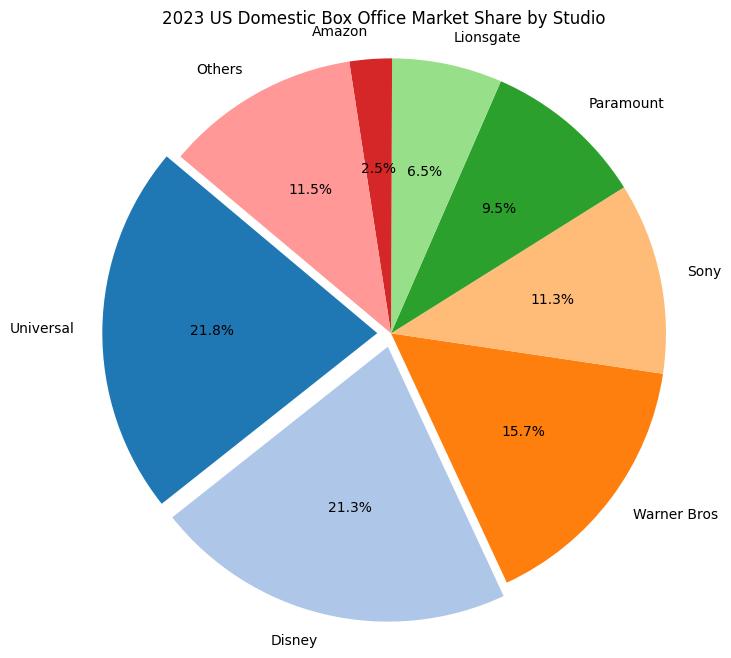

In [31]:
import matplotlib.pyplot as plt

labels = [
    'Universal', 'Disney', 'Warner Bros', 'Sony', 
    'Paramount', 'Lionsgate', 'Amazon', 'Others'
]
sizes = [21.77, 21.26, 15.73, 11.26, 9.55, 6.48, 2.49, 11.46]
colors = plt.cm.tab20.colors[:8]  # Distinct colors

plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels, colors=colors, 
    autopct='%.1f%%', startangle=140, explode=[0.05]*2 + [0]*6
)
plt.title('2023 US Domestic Box Office Market Share by Studio')
plt.axis('equal')  # Keep it circular
plt.show()
